The 'observational policy' is not really a randomized trial in that treatment does not depend on cohort. But it does depend on severity, so we should be able to demostrate confounding by severity in the data simulated with this treatment policy. Our goal is to be abe to train a causal model on observational data, even if it includes confounders, and be able to use that model to create a useful (sim) simulation.

I have now added some sort of random noise to all variables.

In [1]:
import pandas as pd
import numpy as np
import math
from numpy.random import default_rng

my_rng = default_rng(seed=42) # random number generator

NUM_COHORTS = 16
MAX_DOSE = 3.0 # we want doses from 0 to MAX_DOSE in evenly spaced increments
SEVERITY_CEILING = 125; # Max expected severity. Maybe we should normalize severity to always fall into a predefined range?

def new_patient(patient_id, day_number):
    return {
            'patient_id': patient_id,
            'cohort': patient_id % NUM_COHORTS,
            'day_number': day_number,
            'infection': my_rng.integers(low=20, high=40, size=1)[0],
            'severity': my_rng.integers(low=10, high=30, size=1)[0],
            'cum_drug' : 0,
            'outcome':'none',
            'efficacy': 0,
            'drug': 0,
           }


def get_infection(yesterday):
    # depends on: infection_prev
    progression = my_rng.integers(low=0, high=10, size=1)[0]
    return yesterday['infection'] + progression


def get_severity(yesterday):
    # depends on: yesterday's severity, infection, & efficacy
    noise = my_rng.normal(loc=0, scale=1, size=1)
    severity_next = yesterday['severity'] * 1.1 + \
                    yesterday['infection'] * 0.1 - \
                    yesterday['efficacy'] + \
                    noise
    return severity_next
    

def get_cum_drug(yesterday, today):
    # depends on: yesterday's cum_drug_prev, today's drug
    noise = my_rng.normal(loc=0, scale=0.01, size=1)  # !!! surprisingly sensitive !!!
    r = 0.7 + noise  # larger value responds more slowly to changes in dose
    return yesterday['cum_drug'] * r + today['drug'] * (1 - r)


def standard_of_care_policy(yesterday, today):  # default policy
    # depends on: today's severity
    random_dose = my_rng.uniform( low=0.0, high=MAX_DOSE )
    severity_dependent_dose = random_dose * today['severity'] / SEVERITY_CEILING
    return math.floor(10 * severity_dependent_dose)/10 # rounded down to the nearest tenth


def get_efficacy(today):
    # depends on today's drug and cum_drug
    # The amount by which severity will be reduced. 
    # Maybe this shold be a proportion not a fixed amount? Severity can be negative this way.
    noise = my_rng.normal(loc=0, scale=1, size=1)
    sigmoid = lambda x: 1 - 1/(1 + math.exp(-(x - 0.6)/0.1))  # starts at 1, goes to zero
    efficacy = 12 * today['drug'] * sigmoid( today['cum_drug'] ) + noise
    return efficacy


def get_outcome(today):
  # depends on today's severity, infection, and cum_drug
  # possible outcomes: die, recover, none
  noise = my_rng.normal(loc=0, scale=0.1, size=1)
  mortality_threshold = 1.0 + noise # my_rng.uniform(low=0.9, high=1.1)
  if (today['severity']/SEVERITY_CEILING > mortality_threshold):
    return 'die'
  elif today['infection'] >= 100:
    return 'recover'
  else:
    return 'none'


def cycle(patient_id, day_number, yesterday, policy):
    today = {} # new row
    if yesterday is None:
        today = new_patient(patient_id, day_number)
    else:
        today = {
            'patient_id': yesterday['patient_id'],
            'cohort': yesterday['cohort'],
            'day_number': day_number,
        }
        # order matters here
        today['infection'] = get_infection(yesterday)
        today['severity']  = get_severity(yesterday)
        today['drug']      = policy(yesterday, today)
        today['cum_drug']  = get_cum_drug(yesterday, today)
        today['efficacy']  = get_efficacy(today)
        today['outcome']   = get_outcome(today)
    
    return today


def sim_patient(patient_id, policy):
    max_days = 100

    patient_results = []
    yesterday = None
    for day_number in range(max_days):
        today = cycle(patient_id=patient_id, day_number=day_number, yesterday=yesterday, policy=policy)
        patient_results.append(today)
        if today['outcome'] != 'none':
            break
        yesterday = today

    patient_pdf = pd.DataFrame(patient_results)
    return patient_pdf


def sim_population(num_patients, policy=standard_of_care_policy):
    patient_list = []
    for patient_id in range(num_patients):
        patient_list.append(sim_patient(patient_id, policy))

    patient_df = pd.concat(patient_list)
    return patient_df


def rct(policy, patients_per_cohort=100, NUM_COHORTS=16):
    pop = sim_population(patients_per_cohort * NUM_COHORTS, policy)
    pop_out = pop[pop.outcome != 'none'].copy()
    pop_out['survival'] = [1 if x == 'recover' else 0 for x in pop_out.outcome] # copilot figured this out

    rct_results = pop_out.groupby(['cohort']).mean()['survival']
    return rct_results


# Example policy functions:

def completely_random_policy(yesterday, today):
    # does not depend on anything
    dose = math.floor(10 * my_rng.uniform( low=0.0, high=MAX_DOSE ))/10
    return dose


def dose_cohort_policy(yesterday, today):
    cohort = today['cohort']
    dose = MAX_DOSE * cohort / (NUM_COHORTS - 1)
    return dose



In [2]:
rct(dose_cohort_policy, patients_per_cohort=250)

# pop =  sim_population(10 * NUM_COHORTS, policy=dose_cohort_policy)  # pop[pop['cohort'] == 15]
# pop.plot.scatter(x='cum_drug', y='efficacy')

cohort
0     0.000
1     0.056
2     0.372
3     0.488
4     0.320
5     0.140
6     0.080
7     0.060
8     0.048
9     0.032
10    0.020
11    0.020
12    0.012
13    0.004
14    0.000
15    0.000
Name: survival, dtype: float64

In [3]:
# new_patient(1,1)
# cycle(1,1,None)
# sim_patient(1)
# pop = sim_population(100 * NUM_COHORTS)
# np.max(pop['cum_drug'])
# pop

rct(standard_of_care_policy)  # random dose does not depend on cohort

cohort
0     0.12
1     0.20
2     0.12
3     0.06
4     0.13
5     0.14
6     0.15
7     0.13
8     0.18
9     0.17
10    0.17
11    0.19
12    0.16
13    0.17
14    0.21
15    0.14
Name: survival, dtype: float64

In [4]:
def squash_policy(yesterday, today):
    sigmoid = lambda x: 1/(1 + math.exp(-x))
    max_dose = 0.15 * today['cohort']
    dose = max_dose * sigmoid(today['severity']/20)
    return dose


rct(squash_policy, patients_per_cohort=250)

cohort
0     0.004
1     0.016
2     0.064
3     0.292
4     0.452
5     0.440
6     0.356
7     0.332
8     0.272
9     0.172
10    0.172
11    0.096
12    0.132
13    0.068
14    0.068
15    0.028
Name: survival, dtype: float64

In [5]:
def toxicity_policy(yesterday, today):
    sigmoid = lambda x: 1/(1 + math.exp(-x))
    max_dose = 0.15 * today['cohort']
    A = 1000
    dose = max_dose * sigmoid(today['severity']/(A * (yesterday['cum_drug'] + 1/A)))
    return dose


rct(toxicity_policy, patients_per_cohort=250)

# sim_population(100 * NUM_COHORTS, policy=toxicity_policy).to_csv('toxicity_policy_population.csv')

cohort
0     0.004
1     0.008
2     0.048
3     0.096
4     0.284
5     0.468
6     0.636
7     0.732
8     0.700
9     0.476
10    0.332
11    0.172
12    0.080
13    0.056
14    0.036
15    0.016
Name: survival, dtype: float64

In [6]:
def max_cum_drug_policy(yesterday, today):
    max_dose = 0.15 * today['cohort']
    if yesterday['cum_drug'] > 0.6:
        dose = 0
    else:
        dose = max_dose
    return dose


rct(max_cum_drug_policy, patients_per_cohort=250)

# sim_population(100 * NUM_COHORTS, policy=cum_drug_policy).to_csv('cum_drug_policy_population.csv')

cohort
0     0.000
1     0.020
2     0.148
3     0.472
4     0.512
5     0.512
6     0.440
7     0.312
8     0.204
9     0.104
10    0.056
11    0.044
12    0.040
13    0.036
14    0.012
15    0.008
Name: survival, dtype: float64

In [7]:
def cum_drug_policy(yesterday, today):
    max_dose = 0.15 * today['cohort']
    dose = max_dose * 0.5/(yesterday['cum_drug']+0.5)
    return dose


rct(cum_drug_policy, patients_per_cohort=250)

cohort
0     0.000
1     0.012
2     0.056
3     0.160
4     0.348
5     0.560
6     0.652
7     0.700
8     0.680
9     0.528
10    0.464
11    0.360
12    0.188
13    0.104
14    0.064
15    0.048
Name: survival, dtype: float64

In [8]:
def drug_holiday_policy(yesterday, today):
    tx_period = 2
    dose = MAX_DOSE * today['cohort'] / (NUM_COHORTS - 1)

    if today['day_number'] % tx_period == 0:
        drug = 0
    else:
        drug = dose

    return drug


rct(drug_holiday_policy, patients_per_cohort=250)

cohort
0     0.000
1     0.008
2     0.052
3     0.200
4     0.356
5     0.336
6     0.276
7     0.116
8     0.080
9     0.024
10    0.028
11    0.012
12    0.000
13    0.004
14    0.004
15    0.004
Name: survival, dtype: float64

<AxesSubplot:xlabel='day_number'>

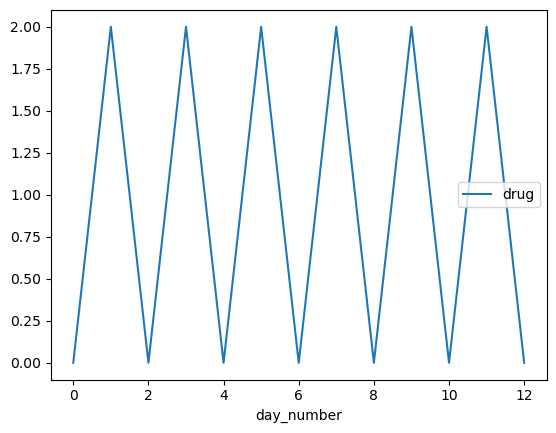

In [9]:
pop =  sim_population(10 * NUM_COHORTS, policy=drug_holiday_policy)
pop = pop[pop['patient_id'] == 10]
pop.plot(x='day_number', y='drug')

# sigmoid = lambda x: 1 - 1/(1 + math.exp(-(x - 0.6)/0.1))
# foo = pd.DataFrame({'x':[i/100 for i in range(100)]}); foo['y'] = [sigmoid(i) for i in foo['x']]
# foo.plot.scatter(x='x', y='y')

In [10]:
pop

,patient_id,cohort,day_number,infection,severity,cum_drug,outcome,efficacy,drug
0,10,10,0,34,17,0,none,0,0.0
1,10,10,1,41,[22.27747967092796],[0.5830408794736572],none,[13.913115004834358],2.0
2,10,10,2,42,[14.090505013167709],[0.41470827835756113],none,[-0.396176369255658],0.0
3,10,10,3,49,[21.325406048055367],[0.9187661064258719],none,[1.4562054547871344],2.0
4,10,10,4,55,[27.78730461945513],[0.6489550389959176],none,[0.9572704867362641],0.0
5,10,10,5,57,[34.84215309863457],[1.0468210119002395],none,[1.368455705229538],2.0
6,10,10,6,62,[41.89879494856113],[0.7314587099645223],none,[-1.1914520386726346],0.0
7,10,10,7,64,[52.833456119274196],[1.11385073835002],none,[-1.1615739630008306],2.0
8,10,10,8,64,[65.80115843817688],[0.7635538368301986],none,[0.6329292016853681],0.0
9,10,10,9,64,[78.16751017282051],[1.1140483865698085],none,[-1.2009828595689342],2.0
